### Import all packages

In [26]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.cross_validation import train_test_split
from sklearn import feature_selection as f_select
import patsy
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn import preprocessing
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from scipy.stats import probplot
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_validation import KFold

# sns.set(style="darkgrid")
# sns.set_color_codes("muted")
%matplotlib inline

### Read and clean the dataset

In [27]:
#Import pickled UFC dataset
with open ('ufc_dataset.pkl','rb') as picklefile:
    dataset = pickle.load(picklefile)

In [28]:
#Only interested in ppv data that is not null
dataset2 = dataset[dataset.ppv.notnull()]

In [29]:
#Create the Fight Number to be able to sort it in acsending order
dataset2['fightnum'] = [int(fight.split(' ')[1]) for fight in dataset2['fight']]
dataset2 = dataset2.sort_values(['fightnum'], ascending=True)

In [30]:
#Ticketrev, attend, and tv rate have some NaN values, I will use the mean to fill them in 
dataset2.fillna(dataset2.mean(),inplace=True)
# rename superstar column into tech_star
dataset2['tech_star'] = dataset2['superstar']

dataset2 = dataset2.drop(['superstar'],1)


In [31]:
#Rename megastar as fan favorite
dataset2['fan_fav'] = dataset2['megastar']
dataset2 = dataset2.drop(['megastar'],1)

In [9]:
dataset2.columns

Index(['fight', 'bouts', 'attend', 'ticketrev', 'ppv', 'tvrate', 'strikes',
       'takedowns', 'submission', 'passes', 'lightfights', 'heavyfights',
       'women', 'men', 'belts', 'KO', 'DEC', 'SUB', 'Other', 'rematch',
       'rival', 'rounds', 'tottime', 'fightnum', 'tech_star', 'fan_fav'],
      dtype='object')

In [10]:
#Reset the index after resorting the dataframe

dataset2 = dataset2.reset_index(drop=True)

In [21]:
dataset2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 27 columns):
fight          114 non-null object
bouts          114 non-null int64
attend         114 non-null float64
ticketrev      114 non-null float64
ppv            114 non-null int64
tvrate         114 non-null float64
strikes        114 non-null int64
takedowns      114 non-null int64
submission     114 non-null int64
passes         114 non-null int64
lightfights    114 non-null int64
heavyfights    114 non-null int64
women          114 non-null int64
men            114 non-null int64
belts          114 non-null int64
KO             114 non-null int64
DEC            114 non-null int64
SUB            114 non-null int64
Other          114 non-null int64
rematch        114 non-null int64
rival          114 non-null int64
rounds         114 non-null int64
tottime        114 non-null int64
fightnum       114 non-null int64
tech_star      114 non-null int64
fan_fav        114 non-null int64
log_

In [11]:
dataset2.head()

,fight,bouts,attend,ticketrev,ppv,tvrate,strikes,takedowns,submission,passes,...,DEC,SUB,Other,rematch,rival,rounds,tottime,fightnum,tech_star,fan_fav
0,UFC 100,11,10871.0,5128490.0,1300000,1.103868e+06,538,33,17,31,...,6,3,0,1,2,28,7153,100,3,3
1,UFC 101,11,17411.0,3560852.0,850000,1.103868e+06,514,30,11,43,...,6,2,0,0,0,29,7457,101,2,1
2,UFC 102,11,16088.0,1920000.0,435000,1.103868e+06,482,26,10,25,...,5,1,0,0,0,24,5074,102,2,0
3,UFC 103,13,17428.0,2400000.0,375000,1.400000e+06,648,22,9,21,...,4,2,0,0,0,27,5366,103,3,0
4,UFC 104,11,14892.0,1913093.0,500000,1.400000e+06,694,31,8,21,...,5,1,0,0,0,28,6626,104,4,0


# I. Exploratory Analysis

### Get KDE PLOT of PPV Buys

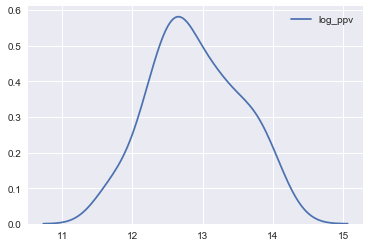

In [508]:
sns.kdeplot(dataset2.log_ppv)

### Find distribution of PPV Buys 

Text(0.5,1,'Distribution of PPV Buys')

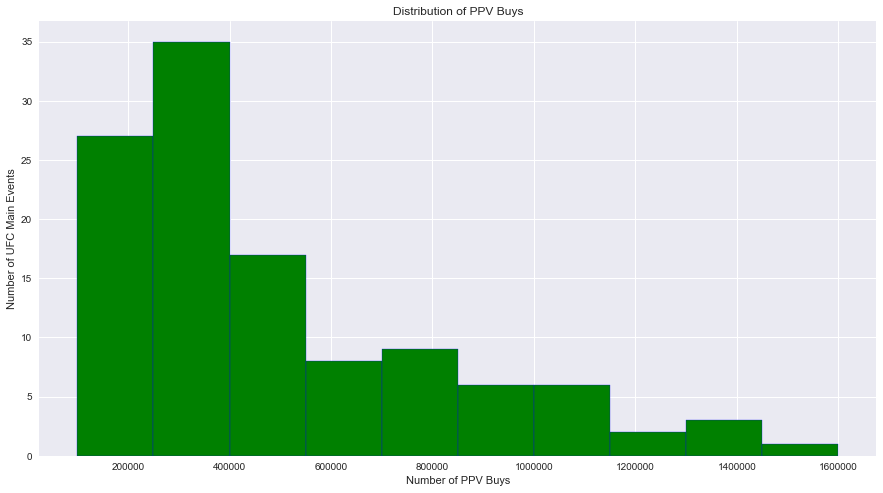

In [493]:
plt.figure(figsize=(15,8))
plt.hist(dataset2.ppv, color = 'green',edgecolor = 'blue',align = 'mid')

plt.xlabel('Number of PPV Buys')
plt.ylabel('Number of UFC Main Events')
plt.title('Distribution of PPV Buys')

### Obtain boxplot of PPV Buys

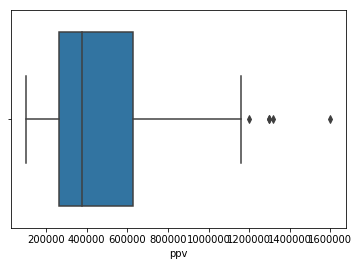

In [28]:
sns.boxplot(dataset2.ppv)

### Tranform Target Variables

In [34]:
#Due to this positive skew we will take the log of the ppv
dataset2['log_ppv'] = np.log(dataset2.ppv)

Text(0.5,1,'Frequency of Log PPV Buys')

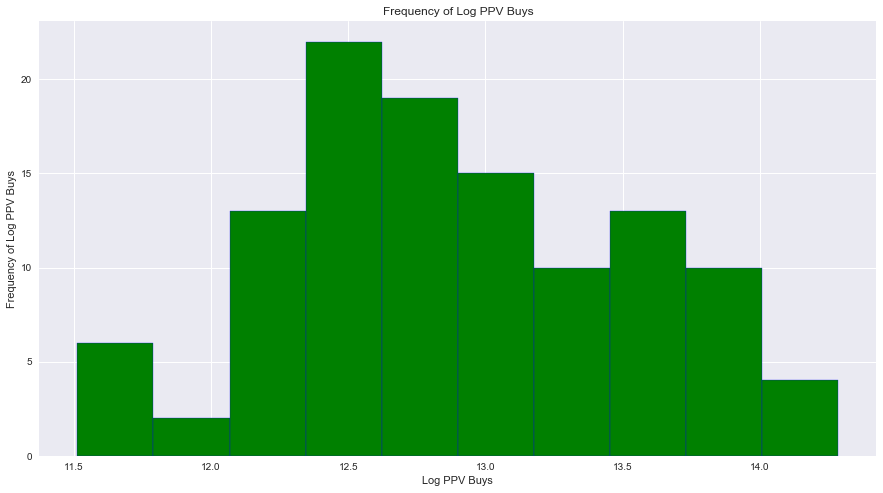

In [499]:
plt.figure(figsize=(15,8))
plt.hist(dataset2.log_ppv, color = 'green',edgecolor = 'blue',align = 'mid')
  #The log will help make the graph look like a normal distribution
plt.xlabel('Log PPV Buys')
plt.ylabel('Frequency of Log PPV Buys')
plt.title('Frequency of Log PPV Buys')

In [22]:
#Separate independent and dependent variables and will use variables with the highest correlations

X = dataset2.drop(['fightnum','fight','ppv','log_ppv'],1)
#include only variables that have a relatively higher correlation
X_var = X[['attend','ticketrev','tvrate','lightfights','heavyfights','women','belts','tech_star','rival','fan_fav']]
y = dataset2[['ppv']]
y_log = dataset2[['log_ppv']]


In [524]:
dataset2.columns

Index(['fight', 'bouts', 'attend', 'ticketrev', 'ppv', 'tvrate', 'strikes',
       'takedowns', 'submission', 'passes', 'lightfights', 'heavyfights',
       'women', 'men', 'belts', 'KO', 'DEC', 'SUB', 'Other', 'rematch',
       'rival', 'rounds', 'tottime', 'fightnum', 'tech_star', 'fan_fav',
       'log_ppv'],
      dtype='object')

### Create pairplot to check correlations

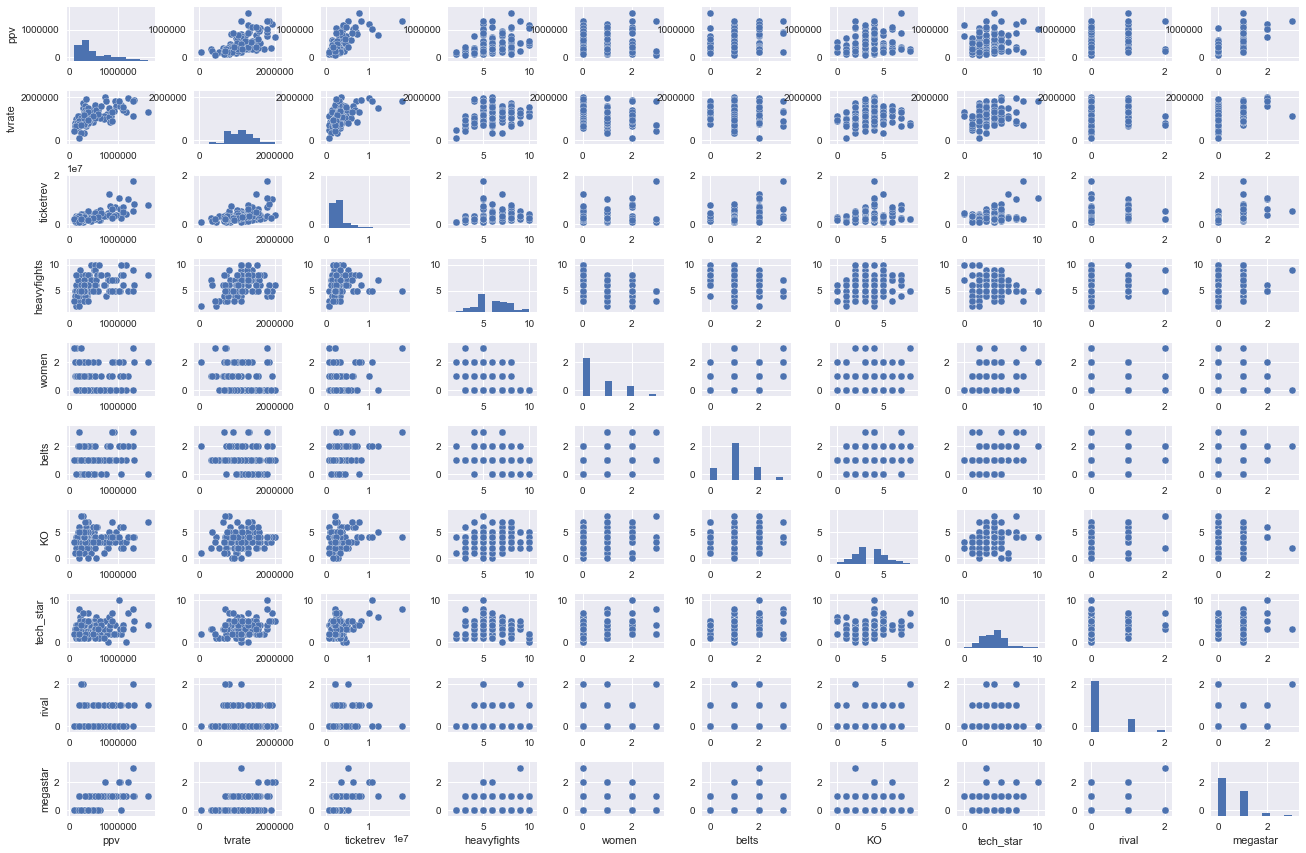

In [487]:
sns.pairplot(dataset2[['ppv','tvrate','ticketrev','heavyfights','women','belts','KO','tech_star'
                      ,'rival','megastar']], size = 1.2, aspect=1.5);

In [525]:
dataset2.corr()

,bouts,attend,ticketrev,ppv,tvrate,strikes,takedowns,submission,passes,lightfights,...,SUB,Other,rematch,rival,rounds,tottime,fightnum,tech_star,fan_fav,log_ppv
bouts,1.000000,0.265984,0.079319,0.060285,-0.057842,0.582499,0.181836,-0.189814,0.096396,0.357896,...,-0.105204,-0.116471,0.105970,0.158520,0.543523,0.402302,0.229506,0.206693,0.017314,0.071050
attend,0.265984,1.000000,0.407263,0.215831,0.100474,0.076428,-0.030127,-0.165304,-0.071061,-0.056503,...,-0.069862,-0.016300,-0.074254,-0.053391,0.009221,0.011271,0.071657,0.086307,0.082696,0.203378
ticketrev,0.079319,0.407263,1.000000,0.675660,0.466792,-0.058847,-0.086647,-0.099490,-0.121426,-0.070316,...,-0.148970,0.094587,-0.032029,0.123667,0.063633,0.020535,0.116674,0.376835,0.482445,0.596661
ppv,0.060285,0.215831,0.675660,1.000000,0.593068,-0.081906,0.027353,0.001475,-0.032394,-0.299869,...,-0.100716,0.109714,0.010434,0.294642,-0.003915,-0.027832,-0.073991,0.109618,0.696544,0.945756
tvrate,-0.057842,0.100474,0.466792,0.593068,1.000000,-0.209887,-0.004165,0.026499,-0.103500,-0.342643,...,-0.265634,0.031172,-0.123983,0.042381,-0.094034,-0.066678,-0.382683,0.245589,0.385764,0.636035
strikes,0.582499,0.076428,-0.058847,-0.081906,-0.209887,1.000000,0.124132,-0.298510,0.045490,0.462099,...,-0.221408,-0.065376,0.177234,0.194794,0.723465,0.667948,0.544288,0.262923,-0.067027,-0.115967
takedowns,0.181836,-0.030127,-0.086647,0.027353,-0.004165,0.124132,1.000000,0.230230,0.500107,-0.081781,...,0.018259,-0.183100,-0.030610,-0.166630,0.427627,0.398974,-0.196329,-0.135149,0.012439,0.036711
submission,-0.189814,-0.165304,-0.099490,0.001475,0.026499,-0.298510,0.230230,1.000000,0.322870,-0.308706,...,0.470905,-0.130042,-0.115368,-0.040158,-0.074038,-0.055622,-0.462035,-0.194055,-0.014245,0.046193
passes,0.096396,-0.071061,-0.121426,-0.032394,-0.103500,0.045490,0.500107,0.322870,1.000000,-0.140658,...,0.212274,-0.240386,-0.047006,-0.133863,0.267648,0.303008,-0.109624,-0.160358,-0.014714,-0.056578
lightfights,0.357896,-0.056503,-0.070316,-0.299869,-0.342643,0.462099,-0.081781,-0.308706,-0.140658,1.000000,...,-0.089294,0.053616,0.112997,0.052632,0.347898,0.269434,0.613556,0.202710,-0.137984,-0.352749


Text(0.5,1,'PPV Buys vs Ticket Revenue')

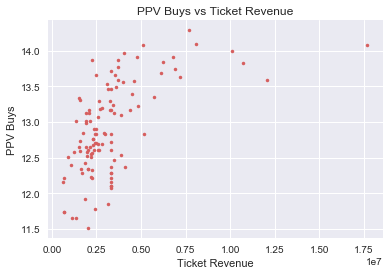

In [40]:
# Plot correlation between ticket revenue and ppv buys
plt.plot(dataset2.ticketrev,dataset2.log_ppv,'r.')
# plt.plot(dataset2.ticketrev,dataset2.ppv,'b.')
plt.xlabel('Ticket Revenue')
plt.ylabel('PPV Buys')
plt.title('PPV Buys vs Ticket Revenue')

Text(0.5,1,'PPV Buys By UFC Fight')

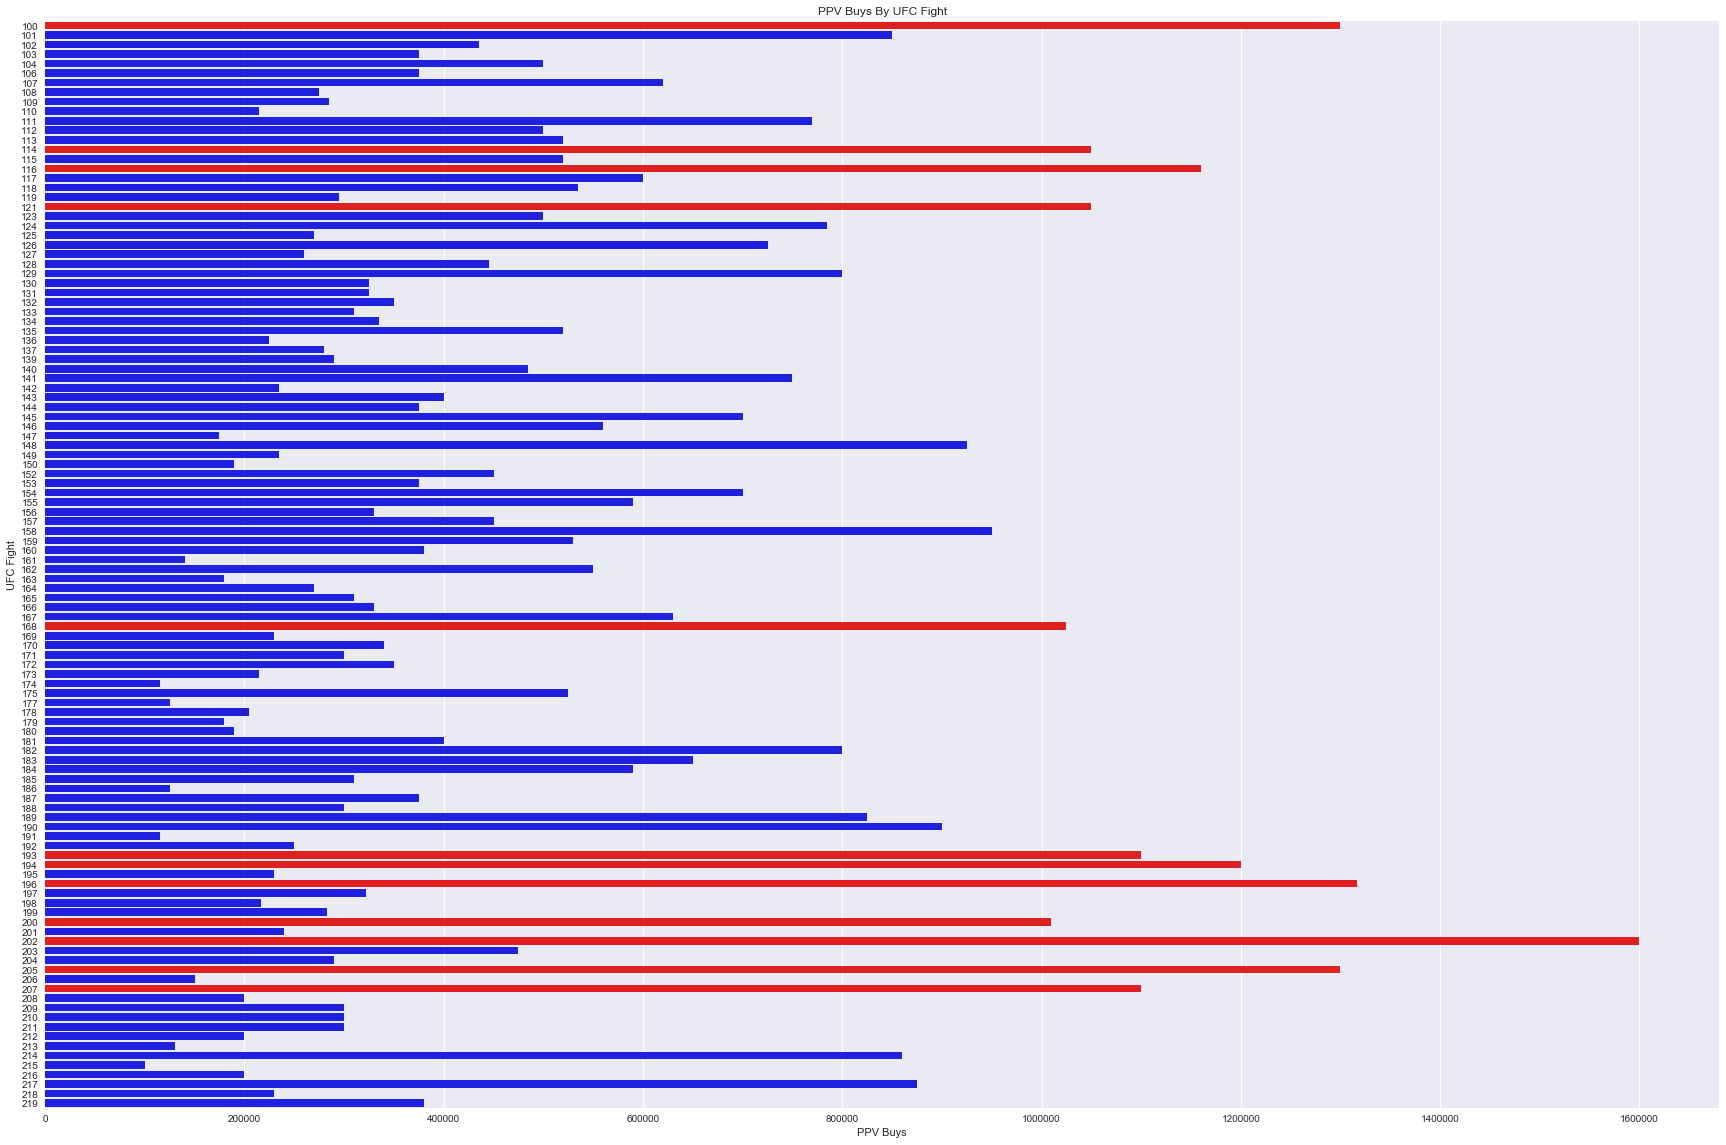

In [41]:
# Create horizontal bar graph and color bars red if it surpasses 1 million PPV Buys

colors = ['red' if (x > 1000000) else 'blue' for x in dataset2['ppv']]
fights = dataset2.fightnum

values = dataset2.ppv
# Create barplot 
ax = plt.figure(figsize=(30,20))
ax = sns.barplot(x=values,y=fights,palette=colors, orient='h')
plt.xlabel('PPV Buys')
plt.ylabel('UFC Fight')
plt.title('PPV Buys By UFC Fight')


### Find correlation between all variables

In [42]:
dataset2.columns

Index(['fight', 'bouts', 'attend', 'ticketrev', 'ppv', 'tvrate', 'strikes',
       'takedowns', 'submission', 'passes', 'lightfights', 'heavyfights',
       'women', 'men', 'belts', 'KO', 'DEC', 'SUB', 'Other', 'rematch',
       'rival', 'megastar', 'rounds', 'tottime', 'fightnum', 'tech_star',
       'log_ppv'],
      dtype='object')

Text(0.5,1,'Log of PPV Buys vs. Number of Light Weight Fights')

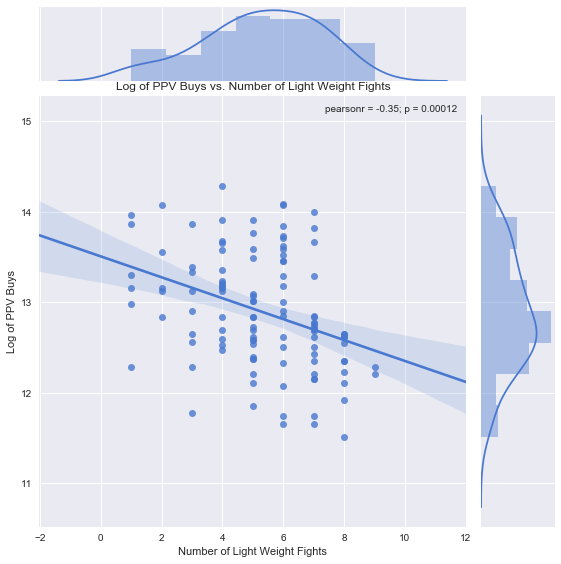

In [648]:
#Create joint plots on three of the highest correlation values
seaborn.jointplot(x='lightfights', y='log_ppv', data = dataset2, kind = 'reg', size = 8, color = 'b')
plt.xlabel('Number of Light Weight Fights')
plt.ylabel("Log of PPV Buys")
plt.title('Log of PPV Buys vs. Number of Light Weight Fights')

Text(0.5,1,'Number of Log PPV Buys vs. Number of Fan Favorites')

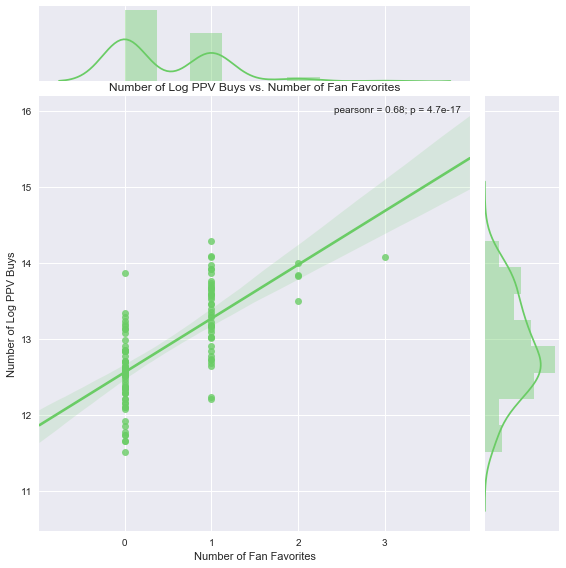

In [486]:

seaborn.jointplot(x='megastar', y='log_ppv', data = dataset2, kind = 'reg', size = 8, color = 'g')
plt.xlabel('Number of Fan Favorites')
# fig.axes.set_xticklabels([str(int(x/1e3)) for x in plt.axes.get_xticks()]);
plt.ylabel("Number of Log PPV Buys")
plt.title('Number of Log PPV Buys vs. Number of Fan Favorites')

Text(0.5,1,'Number of Log PPV Buys vs. Ticket Revenue')

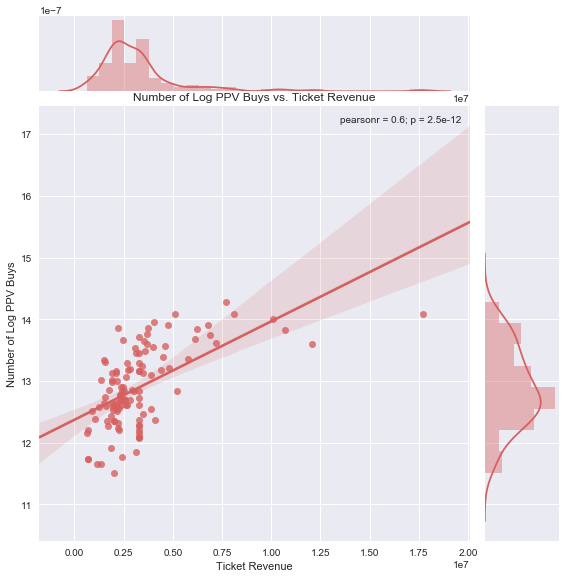

In [1134]:
import seaborn
seaborn.jointplot(x='ticketrev', y='log_ppv', data = dataset2, kind = 'reg', size = 8, color = 'r')
plt.xlabel('Ticket Revenue')
plt.ylabel("Number of Log PPV Buys")
plt.title('Number of Log PPV Buys vs. Ticket Revenue')

## II. Regression Modeling

In [32]:
import statsmodels.formula.api as smf
model = smf.ols('ppv ~attend+ticketrev+tvrate+lightfights+heavyfights+women+belts+tech_star+rival+fan_fav',data=dataset2)
fit = model.fit()
fit.summary()
#Although r2 is greater here than in log ppv, Omnibus and JB errors are too high. Log ppv model has dramatically reduced
#omnibus and JB

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ppv   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     37.55
Date:                Fri, 02 Feb 2018   Prob (F-statistic):           6.08e-30
Time:                        12:42:59   Log-Likelihood:                -1518.7
No. Observations:                 114   AIC:                             3059.
Df Residuals:                     103   BIC:                             3090.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -2.182e+05   1.98e+05     -1.105      0.272    -6.1e+05    1.74e+05
attend         -1.2186      2.565     -0.475      0.636      -6.307       3.869
ticketrev       0.0482      0.009      5.224      0.000       0.030       0.066
tvrate          0.2663      0.053      5.048      0.000       0.162       0.371
lightfights -1195.4218   1.83e+04     -0.065      0.948   -3.75e+04    3.51e+04
heavyfights  3.629e+04   1.88e+04      1.932      0.056    -970.333    7.35e+04
women        5.212e+04   2.02e+04      2.578      0.011     1.2e+04    9.22e+04
belts        3.457e+04   2.49e+04      1.388      0.168   -1.48e+04     8.4e+04
tech_star   -3.489e+04      1e+04     -3.486      0.001   -5.47e+04    -1.5e+04
rival        1.207e+05   3.15e+04      3.825      0.000    5.81e+04    1.83e+05
fan_fav      1.719e+05   3.04e+04      5.645      0.000    1.11e+05    2.32e+05
==============================================================================
Omnibus:                       13.466   Durbin-Watson:                   2.258
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.431
Skew:                           0.712   Prob(JB):                     0.000446
Kurtosis:                       4.106   Cond. No.                     5.71e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.71e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [35]:
model1 = smf.ols('log_ppv ~ attend+ticketrev+tvrate+lightfights+heavyfights+women+belts+tech_star+rival+fan_fav',data=dataset2)
fit1 = model1.fit()
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_ppv   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     30.08
Date:                Fri, 02 Feb 2018   Prob (F-statistic):           3.13e-26
Time:                        12:43:30   Log-Likelihood:                -31.470
No. Observations:                 114   AIC:                             84.94
Df Residuals:                     103   BIC:                             115.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      11.1607      0.426     26.178      0.000      10.315      12.006
attend      -6.201e-07   5.54e-06     -0.112      0.911   -1.16e-05    1.04e-05
ticketrev     5.79e-08   1.99e-08      2.909      0.004    1.84e-08    9.74e-08
tvrate       6.324e-07   1.14e-07      5.554      0.000    4.07e-07    8.58e-07
lightfights     0.0181      0.039      0.458      0.648      -0.060       0.096
heavyfights     0.0980      0.041      2.416      0.017       0.018       0.178
women           0.0131      0.044      0.300      0.765      -0.073       0.100
belts           0.1053      0.054      1.958      0.053      -0.001       0.212
tech_star      -0.0483      0.022     -2.238      0.027      -0.091      -0.006
rival           0.1959      0.068      2.878      0.005       0.061       0.331
fan_fav         0.3577      0.066      5.444      0.000       0.227       0.488
==============================================================================
Omnibus:                        1.515   Durbin-Watson:                   2.150
Prob(Omnibus):                  0.469   Jarque-Bera (JB):                1.462
Skew:                          -0.175   Prob(JB):                        0.481
Kurtosis:                       2.569   Cond. No.                     5.71e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.71e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [656]:
#Checking if log ticketrev will improve the model, it only increases r2 by .001 so I will not log ticketrev
# model = smf.ols('log_ppv ~ attend+log_ticketrev+tvrate+lightfights+heavyfights+women+belts+tech_star+rival+megastar',data=dataset2)
# fit = model.fit()
# fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_ppv   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     30.22
Date:                Wed, 31 Jan 2018   Prob (F-statistic):           2.62e-26
Time:                        19:25:47   Log-Likelihood:                -31.269
No. Observations:                 114   AIC:                             84.54
Df Residuals:                     103   BIC:                             114.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         7.9494      1.148      6.923      0.000       5.672      10.227
attend        -1.669e-07   5.45e-06     -0.031      0.976    -1.1e-05    1.07e-05
log_ticketrev     0.2339      0.079      2.976      0.004       0.078       0.390
tvrate         6.384e-07   1.13e-07      5.668      0.000    4.15e-07    8.62e-07
lightfights       0.0088      0.039      0.225      0.822      -0.069       0.086
heavyfights       0.0850      0.040      2.108      0.037       0.005       0.165
women             0.0349      0.043      0.817      0.416      -0.050       0.120
belts             0.1120      0.053      2.106      0.038       0.007       0.218
tech_star        -0.0394      0.021     -1.880      0.063      -0.081       0.002
rival             0.1766      0.068      2.580      0.011       0.041       0.312
megastar          0.3518      0.066      5.325      0.000       0.221       0.483
==============================================================================
Omnibus:                        1.391   Durbin-Watson:                   2.143
Prob(Omnibus):                  0.499   Jarque-Bera (JB):                1.451
Skew:                          -0.213   Prob(JB):                        0.484
Kurtosis:                       2.647   Cond. No.                     4.27e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.27e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
#Sort the correlations by descending order with respect to log_ppv
dataset2.corr()['log_ppv'].sort_values(ascending=False)

log_ppv        1.000000
ppv            0.945756
fan_fav        0.684376
tvrate         0.636035
ticketrev      0.596661
heavyfights    0.410474
rival          0.263060
belts          0.206176
attend         0.203378
tech_star      0.121231
men            0.120958
KO             0.115108
Other          0.114884
bouts          0.071050
submission     0.046193
takedowns      0.036711
DEC           -0.028123
rounds        -0.037491
tottime       -0.048620
rematch       -0.050113
passes        -0.056578
women         -0.082990
SUB           -0.103044
strikes       -0.115967
fightnum      -0.191897
lightfights   -0.352749
Name: log_ppv, dtype: float64

### Perform Train Test Split To Validate if the model performs well on test data

In [37]:
# Create training and test set model 

model2 = LinearRegression()

X_train,X_test,y_train,y_test = train_test_split(X_var,y_log,test_size = .3)  #Test size will be 30%
#Fitting the model against the training data
model2.fit(X_train,y_train)
model2.score(X_test,y_test) #Our score decreased on the test set but this gives us a more accurate representation of
                        #how well the model will actually perform for future data 

0.73951978430411569

In [698]:
''' 
**Creating Linear Regression model using sm**
import patsy
y, X = patsy.dmatrices('log_ppv ~ attend+log_ticketrev+tvrate+lightfights+heavyfights+women+belts+tech_star+rival+megastar', data=dataset2, return_type="dataframe")

model = sm.OLS(y, X)

fit = model.fit()

fit.summary()
'''

' \n**Creating Linear Regression model using sm**\nimport patsy\ny, X = patsy.dmatrices(\'log_ppv ~ attend+log_ticketrev+tvrate+lightfights+heavyfights+women+belts+tech_star+rival+megastar\', data=dataset2, return_type="dataframe")\n\nmodel = sm.OLS(y, X)\n\nfit = model.fit()\n\nfit.summary()\n'

Text(0.5,1,'Actual vs Predicted PPV Buys')

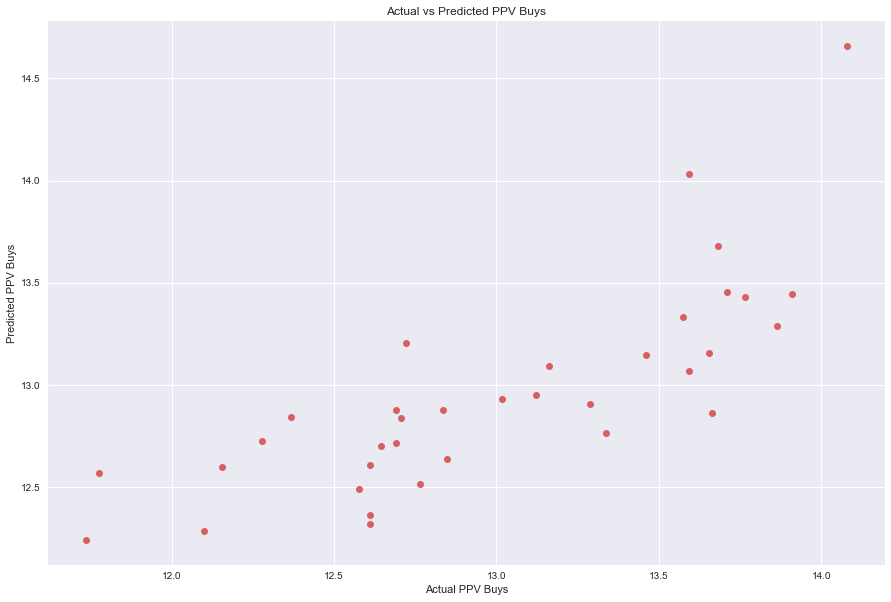

In [1183]:
#Graph out predicted values vs actual values
#Predict against actual values
plt.figure(figsize=(15,10))
y_predict = model2.predict(X_test)
plt.plot(y_test,y_predict,'r.',marker = 'o')

plt.xlabel('Actual PPV Buys')
plt.ylabel('Predicted PPV Buys')
plt.title("Actual vs Predicted PPV Buys")


Text(0.5,1,'Predicted vs. Actual PPV Buy')

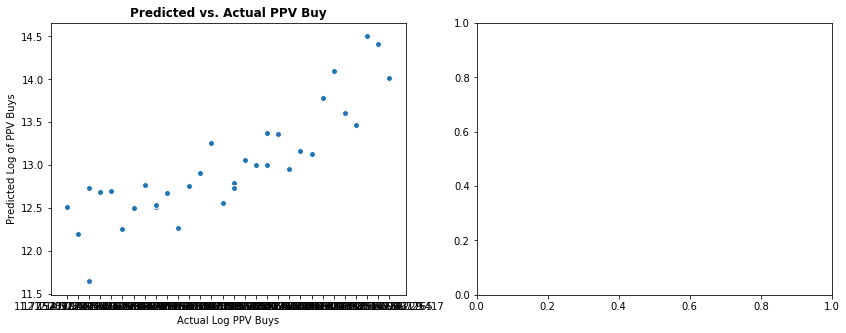

In [49]:
y_predict = model2.predict(X_test)
data_r['residuals'] = y_test-y_predict
data_r['predict'] = y_predict
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14,5))
ax[0].scatter(y_test, y_predict, edgecolors=(1, 1, 1))
ax[0].set_xlabel('Actual Log PPV Buys')
ax[0].set_ylabel('Predicted Log of PPV Buys')
ax[0].set_title('Predicted vs. Actual PPV Buy',fontweight='bold')

# ax[1].hist(residuals,bins=15);
# ax[1].set_xlabel('Residual')
# ax[1].set_ylabel('Count')
# ax[1].set_title('Histogram of Residuals',fontweight='bold');


In [45]:
data_r['fightnum'] = dataset2[['fightnum']]

In [46]:
data_r

,residuals,fightnum
0,NaN,219
1,NaN,218
2,NaN,217
3,NaN,216
4,0.121677,215
5,NaN,214
6,NaN,213
7,NaN,212
8,NaN,211
9,NaN,210


Text(0.5,1,'Residuals over Time')

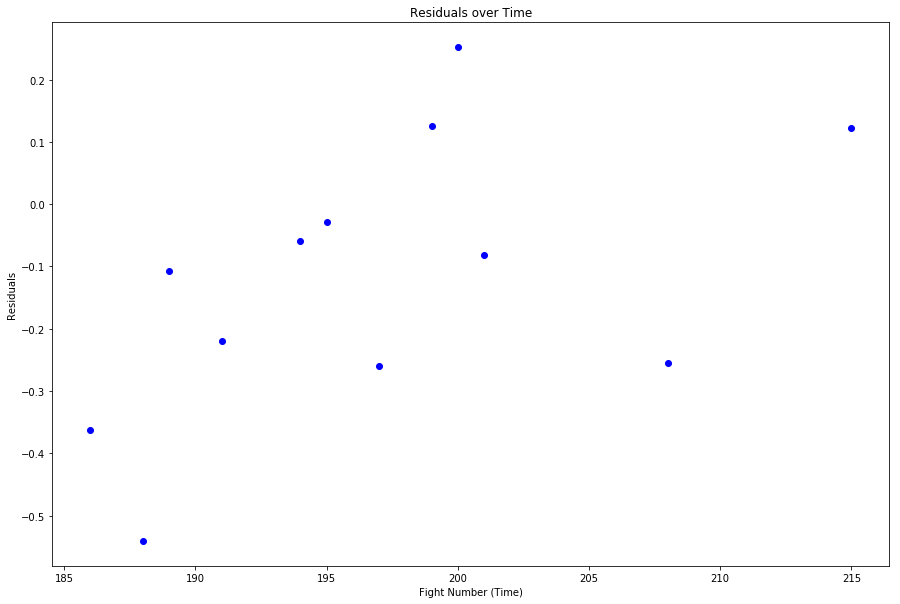

In [48]:
plt.figure(figsize=(15,10))
plt.plot(data_r.fightnum,data_r.residuals,'b.',marker = 'o')
plt.xlabel('Fight Number (Time)')
plt.ylabel('Residuals')
plt.title("Residuals over Time")


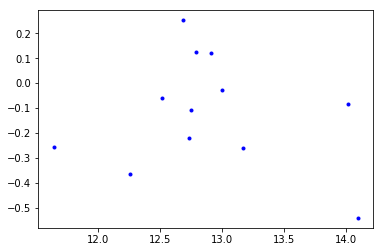

In [53]:
# Residual plot: plot residuals vs predicted

# data_r['residuals']= y_test-data_r.predict
plt.plot(data_r['predict'], data_r['residuals'],'b.')

Text(0.5,1,'Residual Counts')

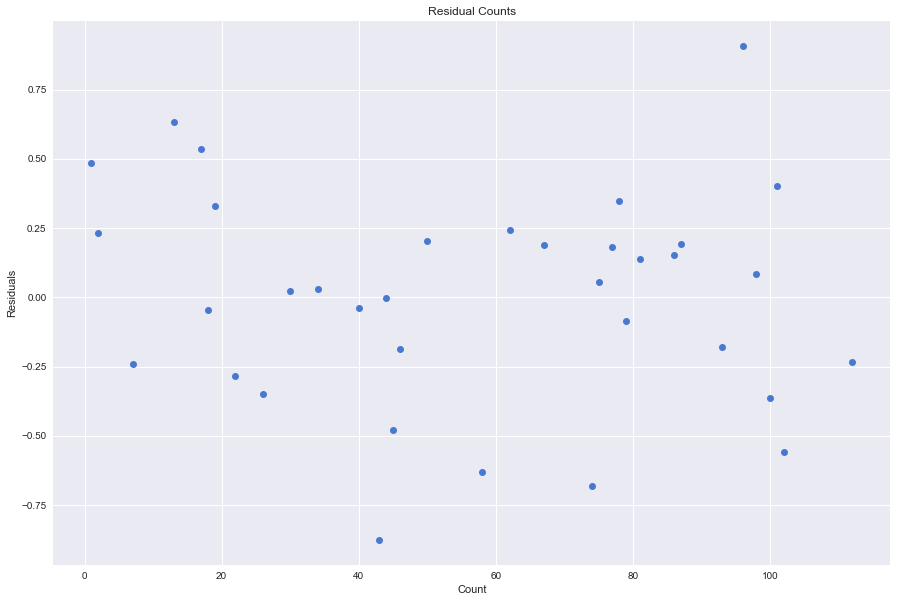

In [1185]:
plt.figure(figsize=(15,10))
plt.plot(residuals,'b.',marker='o')
plt.xlabel('Count')
plt.ylabel('Residuals')
plt.title("Residual Counts")

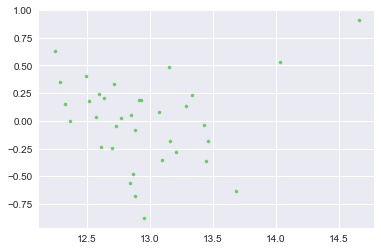

In [1166]:
plt.plot(y_predict,residuals,'g.')

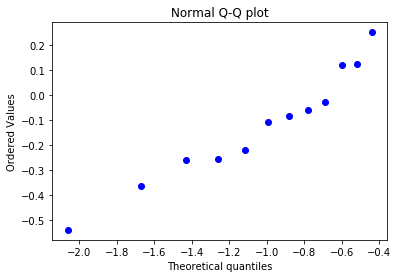

In [61]:

probplot(data_r['residuals'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

### Find train and test errors

In [711]:
#Create the y_pred_train to find y predicted train error
y_pred_train = model2.predict(X_train)

In [712]:
#Create the y_pred_test error to find y predicted test error
y_pred_test = model2.predict(X_test)

In [713]:
#Find the mean absolute error and mean squared error

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
mae_train = mean_absolute_error(y_train,y_pred_train)
mse_train = mean_squared_error(y_train,y_pred_train)

mae_test = mean_absolute_error(y_test,y_pred_test)
mse_test = mean_squared_error(y_test,y_pred_test)



In [718]:
y_pred_test,y_test

(array([[ 13.2050151 ],
        [ 12.48236464],
        [ 12.18243166],
        [ 12.36304695],
        [ 12.04357123],
        [ 13.95280427],
        [ 13.16873759],
        [ 14.40020029],
        [ 13.16821975],
        [ 12.98932657],
        [ 12.19626505],
        [ 12.55115694],
        [ 13.22063115],
        [ 12.83105315],
        [ 13.1295266 ],
        [ 13.00672271],
        [ 12.51642704],
        [ 12.14555403],
        [ 12.20231436],
        [ 12.11312635],
        [ 13.48107622],
        [ 12.50430841],
        [ 12.47273672],
        [ 13.2738102 ],
        [ 12.99713024],
        [ 12.62019022],
        [ 12.86429556],
        [ 14.73600071],
        [ 12.37378111],
        [ 12.58787746],
        [ 12.76874373],
        [ 14.1865606 ],
        [ 13.31269771],
        [ 13.19085737],
        [ 12.6528339 ]]),        log_ppv
 14   13.161584
 29   12.765688
 85   11.652687
 89   12.345835
 68   12.278393
 90   14.090867
 70   13.171154
 88   13.997832
 32   13.161584

In [714]:
mae_train

0.24997090345011294

In [715]:
mse_train

0.10060474740204579

In [716]:
mae_test

0.26870784486413135

In [717]:
mse_test

0.11580326376199075

### Check Accuracy of this model using Cross Validation

In [842]:
from sklearn.cross_validation import cross_val_score
lr = LinearRegression()
mse_scores = cross_val_score(lr,X_var,y_log,cv = 10, scoring = 'mean_squared_error')

In [843]:
mse_scores

array([-0.14142662, -0.12250485, -0.05748421, -0.08970899, -0.13183877,
       -0.08930316, -0.08887079, -0.10901969, -0.17150133, -0.2547803 ])

In [844]:
-np.mean(mse_scores)

0.12564387096575055

In [755]:
mae_scores = cross_val_score(lr,X_var,y_log,cv = 10, scoring = 'mean_absolute_error')

In [756]:
-np.mean(mae_scores)

0.28104484276830222

In [847]:
r_scores = cross_val_score(lr,X_var,y_log,cv = 10, scoring = 'r2')

In [848]:
r_scores

array([ 0.42844388,  0.38651257,  0.46698242,  0.68177179,  0.54362758,
        0.69063108,  0.7855099 ,  0.82058802,  0.74463588,  0.38780459])

In [849]:
np.mean(r_scores)

0.59365077112581766

### Perform K-Fold Regression

In [856]:
#K-Fold Regression 
#Define the model

model3 = LinearRegression()
rscores = []
kf = KFold(n=len(X_var),n_folds = 10 , shuffle = True)  # Performing a 10 - Fold Test
for train, test in kf:  #Assigning my train and test sets
    X_train = X_var.iloc[train]
    y_train = y_log.iloc[train]
    X_test = X_var.iloc[test]
    y_test = y_log.iloc[test]
    pvals = []
    sign_cols = []
for feature in X_train.columns:
    pval = f_select.f_regression(X_train[[feature]],y_train)
    if pval[1][0] < .02:  #If the p value is statistically significant, column name will be added into sign column
        sign_cols.append(feature)
        pvals.append(pval[1][0])
        model3.fit(X_train[sign_cols],y_train)  # fit the model with the training set
        r2 = model3.score(X_test[sign_cols],y_test)  # using the fit model, find R_2 for the test sets
        rscores.append(r2)


In [857]:
rscores

[0.52252838128539536,
 0.50901743015510337,
 0.51939856948695373,
 0.64315437900610695,
 0.66685356694579312]

In [858]:
np.mean(rscores)

0.57219046537587048

In [811]:
# Print out the coefficients of the model
model3.coef_

array([[  4.42044758e-08,   5.95455196e-07,  -8.43523829e-03,
          7.02021170e-02,   1.02943915e-01,   1.78497846e-01,
          3.71222423e-01]])

In [812]:
sign_cols

['ticketrev',
 'tvrate',
 'lightfights',
 'heavyfights',
 'belts',
 'rival',
 'fan_fav']

In [813]:
# print out the intercept 
print(model3.intercept_)

[ 11.37980714]


In [807]:

pd.set_option('display.max_columns', 500)
dataset2.head()

,fight,bouts,attend,ticketrev,ppv,tvrate,strikes,takedowns,submission,passes,lightfights,heavyfights,women,men,belts,KO,DEC,SUB,Other,rematch,rival,rounds,tottime,fightnum,tech_star,fan_fav,log_ppv
0,UFC 100,11,10871.0,5128490.0,1300000,1.103868e+06,538,33,17,31,2,9,0,11,2,2,6,3,0,1,2,28,7153,100,3,3,14.077875
1,UFC 101,11,17411.0,3560852.0,850000,1.103868e+06,514,30,11,43,4,7,0,11,1,3,6,2,0,0,0,29,7457,101,2,1,13.652992
2,UFC 102,11,16088.0,1920000.0,435000,1.103868e+06,482,26,10,25,1,10,0,11,0,5,5,1,0,0,0,24,5074,102,2,0,12.983101
3,UFC 103,13,17428.0,2400000.0,375000,1.400000e+06,648,22,9,21,5,8,0,13,0,7,4,2,0,0,0,27,5366,103,3,0,12.834681
4,UFC 104,11,14892.0,1913093.0,500000,1.400000e+06,694,31,8,21,2,9,0,11,1,5,5,1,0,0,0,28,6626,104,4,0,13.122363


In [ ]:
### Find the Train and Test Error by Polynomial degree

In [113]:
# Checking the accuracy of the model based on mean squared error


# Step through degrees from 0 to 9 and store the training and test (generalization) error.
# create array of zeros,



In [137]:
#Find the error test and training error for tvrevenue and ppv buys by polynomial degree


In [280]:
##Use the significant features that K-Fold Regression determined
X2 = dataset2[['ticketrev', 'tvrate', 'lightfights', 'heavyfights', 'rival', 'megastar']].values
y2 = dataset2.log_ppv.values

In [253]:
dataset2.head()

,fight,bouts,attend,ticketrev,ppv,tvrate,strikes,takedowns,submission,passes,...,Other,rematch,rival,megastar,rounds,tottime,fightnum,tech_star,log_ppv,log_ticketrev
0,UFC 100,11,10871.0,5128490.0,1300000,1.103868e+06,538,33,17,31,...,0,1,2,3,28,7153,100,3,14.077875,15.450322
1,UFC 101,11,17411.0,3560852.0,850000,1.103868e+06,514,30,11,43,...,0,0,0,1,29,7457,101,2,13.652992,15.085510
2,UFC 102,11,16088.0,1920000.0,435000,1.103868e+06,482,26,10,25,...,0,0,0,0,24,5074,102,2,12.983101,14.467836
3,UFC 103,13,17428.0,2400000.0,375000,1.400000e+06,648,22,9,21,...,0,0,0,0,27,5366,103,3,12.834681,14.690979
4,UFC 104,11,14892.0,1913093.0,500000,1.400000e+06,694,31,8,21,...,0,0,0,0,28,6626,104,4,13.122363,14.464232


In [296]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.8)

Text(0.5,1,'Mean Squared Error by Polynomial Degree')

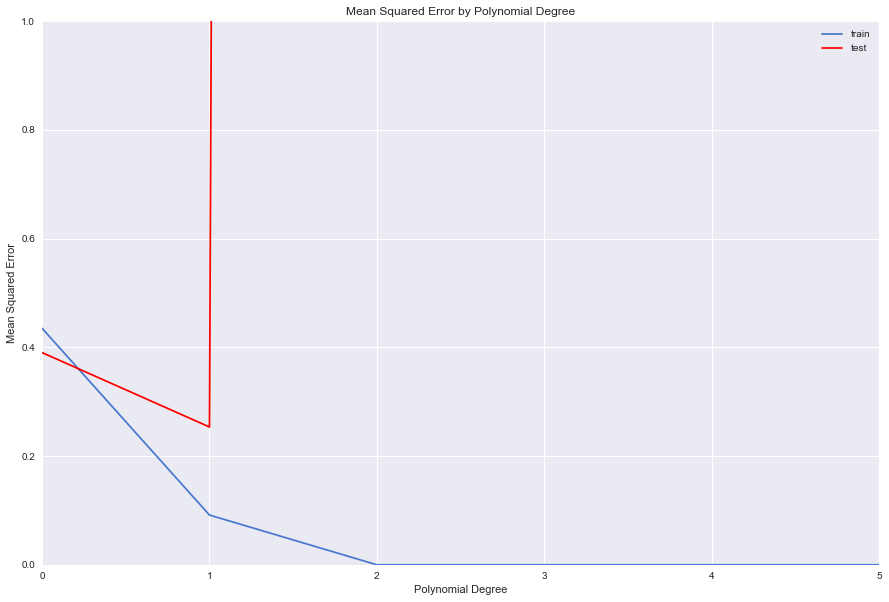

In [300]:
train_error = np.empty(6)
test_error = np.empty(6)
for degree in range(6):
    model3 = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model3.fit(X_train, y_train)
    train_error[degree] = mean_squared_error(y_train, model3.predict(X_train))
    test_error[degree] = mean_squared_error(y_test, model3.predict(X_test))

# Plot the training and test errors against degree
plt.figure(figsize=(15,10))
plt.plot(np.arange(6), train_error, color='b', label='train')
plt.plot(np.arange(6), test_error, color='red', label='test')
plt.ylim((1e-30, 1))
plt.xlim((0,5))
plt.ylabel('Mean Squared Error')
plt.xlabel('Polynomial Degree')
plt.legend(loc='upper right')
plt.title('Mean Squared Error by Polynomial Degree')

### Perform cross validation with Ridge

In [869]:
X_train, X_test, y_train, y_test = train_test_split(X_var, y_log, test_size=0.3)

rcv_model = RidgeCV(cv=10)

rcv_model.fit(X_var, y_log)
rcv_model.score(X_test, y_test)


0.76471061808695784

### Determine optimal alpha with ElasticNet that will minimize MSE

In [1079]:
dataset2.head()

,fight,bouts,attend,ticketrev,ppv,tvrate,strikes,takedowns,submission,passes,lightfights,heavyfights,women,men,belts,KO,DEC,SUB,Other,rematch,rival,rounds,tottime,fightnum,tech_star,fan_fav,log_ppv
0,UFC 100,11,10871.0,5128490.0,1300000,1.103868e+06,538,33,17,31,2,9,0,11,2,2,6,3,0,1,2,28,7153,100,3,3,14.077875
1,UFC 101,11,17411.0,3560852.0,850000,1.103868e+06,514,30,11,43,4,7,0,11,1,3,6,2,0,0,0,29,7457,101,2,1,13.652992
2,UFC 102,11,16088.0,1920000.0,435000,1.103868e+06,482,26,10,25,1,10,0,11,0,5,5,1,0,0,0,24,5074,102,2,0,12.983101
3,UFC 103,13,17428.0,2400000.0,375000,1.400000e+06,648,22,9,21,5,8,0,13,0,7,4,2,0,0,0,27,5366,103,3,0,12.834681
4,UFC 104,11,14892.0,1913093.0,500000,1.400000e+06,694,31,8,21,2,9,0,11,1,5,5,1,0,0,0,28,6626,104,4,0,13.122363


In [1080]:
# Use preprocessing package to normalize all the variables
dataset2_norm=preprocessing.normalize(dataset2.drop(['fight','fightnum'],1),axis=0)
# turn back into a dataframe
dataset2_norm=pd.DataFrame(dataset2_norm,columns=['bouts', 'attend', 'ticketrev', 'ppv', 'tvrate', 'strikes',
       'takedowns', 'submission', 'passes', 'lightfights', 'heavyfights',
       'women', 'men', 'belts', 'KO', 'DEC', 'SUB', 'Other', 'rematch',
       'rival', 'rounds', 'tottime', 'tech_star','fan_fav',
       'log_ppv'])
y_norm=dataset2_norm['log_ppv']
X_norm=dataset2_norm.drop(['log_ppv','ppv'],1)

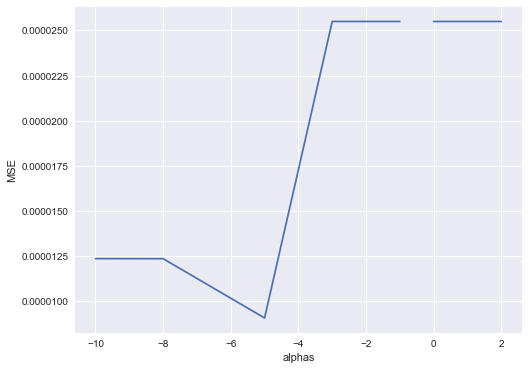

In [1081]:
alphas=[1e-10,1e-8,1e-5,1e-3,1e-1,0,1,100]
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_norm, y_norm, test_size=0.3)

def mse_func(estimator,alpha):
    estimator.alpha=alpha
    model = estimator.fit(X_train1,y_train1)
    mse=mean_squared_error(y_test1, model.predict(X_test1))  
    return mse
    

mse_scores=[]    
for a in alphas:    
    mse_scores.append(mse_func(ElasticNet(),a))
    

#plot of model
plt.figure(figsize=(8,6))
plt.legend()
plt.plot(np.log10(alphas),mse_scores)
plt.legend()
plt.xlabel('alphas')
plt.ylabel('MSE')
plt.show()

In [1082]:
# Perform ElasticNet Regression

kf = KFold(n=len(X_test1), n_folds=5, shuffle=True)

all_mse_scores=[]  #list of MSE Scores for each alpha
alphas=[1e-10,1e-8,1e-5,1e-3,1e-1,0,1,100] # alpha(weight) list

#Create our test and train sets
for train, test in kf:
    X_train=X_norm.iloc[train]
    y_train=y_norm.iloc[train]
    X_test=X_norm.iloc[test]
    y_test=y_norm.iloc[test]
    mse_score1=[]
    for a in alphas:  #Go thru each alpha to check which will produce the lowest MSE score
        estimator=ElasticNet(alpha=a)
        estimator.fit(X_train,y_train)
        mse=mean_squared_error(y_test, estimator.predict(X_test))  
        mse_score1.append(mse)
    all_mse_scores.append(mse_score1)
np.mean(all_mse_scores)

2.1902356757317476e-05

In [906]:
all_mse_scores

[[2.4260899513845792e-05,
  2.4205822744652026e-05,
  9.8018535811502164e-06,
  1.5084706524979384e-05,
  1.5084706524979384e-05,
  2.4261394113056159e-05,
  1.5084706524979384e-05,
  1.5084706524979384e-05],
 [4.9812432727216679e-05,
  4.9766491558761073e-05,
  8.4695739365233237e-06,
  1.5749673102114151e-05,
  1.5749673102114151e-05,
  4.9812891016163402e-05,
  1.5749673102114151e-05,
  1.5749673102114151e-05],
 [5.6593693043168649e-05,
  5.624407152250258e-05,
  1.799880780000742e-05,
  2.0110804812194795e-05,
  2.0110804812194795e-05,
  5.6597245749450365e-05,
  2.0110804812194795e-05,
  2.0110804812194795e-05],
 [8.9846339804404507e-06,
  8.9935475474660724e-06,
  6.0433972343630768e-06,
  4.1272610839363016e-06,
  4.1272610839363016e-06,
  8.9845137332474495e-06,
  4.1272610839363016e-06,
  4.1272610839363016e-06],
 [4.5229154302466099e-05,
  4.503256244692453e-05,
  1.0691227114952387e-05,
  7.3915914779228509e-06,
  7.3915914779228509e-06,
  4.523052053624025e-05,
  7.39159147

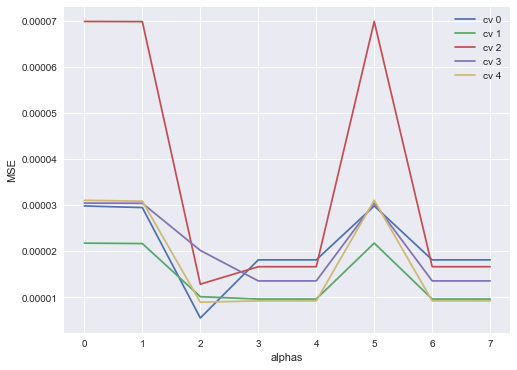

In [1083]:
# Which alpha is the best for our model ? Looks like alpha= 1e-5
plt.figure(figsize=(8,6))

plt.legend()
for i in range(5):
    plt.plot(all_mse_scores[i],label = 'cv %s'%i)
plt.legend()
plt.xlabel('alphas')
plt.ylabel('MSE')
plt.show()

In [895]:
kf = KFold(n=len(X_test1), n_folds=5, shuffle=True)

all_mse_scores=[]  #list of MSE Scores for each alpha
alphas=[1e-10,1e-8,1e-5,1e-3,1e-1,0,1,100] # alpha(weight) list

#Create our test and train sets
for train, test in kf:
    X_train=X_norm.iloc[train]
    y_train=y_norm.iloc[train]
    X_test=X_norm.iloc[test]
    y_test=y_norm.iloc[test]
    mse_score1=[]
    for a in alphas:  #Go thru each alpha to check which will produce the lowest MSE score
        estimator=Lasso(alpha=a)
        estimator.fit(X_train,y_train)
        mse=mean_squared_error(y_test, estimator.predict(X_test))  
        mse_score1.append(mse)
    all_mse_scores.append(mse_score1)
np.mean(all_mse_scores)


1.6228654515946379e-05

In [969]:
all_mse_scores

[[2.0891307153569103e-05,
  2.0824650309567636e-05,
  1.631248984756812e-05,
  1.8341972087336088e-05,
  1.8341972087336088e-05,
  2.0891216130650876e-05,
  1.8341972087336088e-05,
  1.8341972087336088e-05],
 [7.7750907900220206e-05,
  7.6882869755093834e-05,
  1.6937041748531939e-06,
  9.3641795663839692e-06,
  9.3641795663839692e-06,
  7.7761641982106706e-05,
  9.3641795663839692e-06,
  9.3641795663839692e-06],
 [2.1677255289997593e-05,
  2.1395323508557515e-05,
  4.981287223767073e-06,
  7.5623887486395235e-06,
  7.5623887486395235e-06,
  2.1679996250538121e-05,
  7.5623887486395235e-06,
  7.5623887486395235e-06],
 [1.4248897337264408e-05,
  1.4213977044979206e-05,
  7.8381260826393345e-06,
  9.3724746908868866e-06,
  9.3724746908868866e-06,
  1.424924267877565e-05,
  9.3724746908868866e-06,
  9.3724746908868866e-06],
 [4.9029930907137807e-05,
  4.847272944150889e-05,
  1.3805356265114297e-05,
  1.9201967252850241e-05,
  1.9201967252850241e-05,
  4.9035254841896379e-05,
  1.92019672

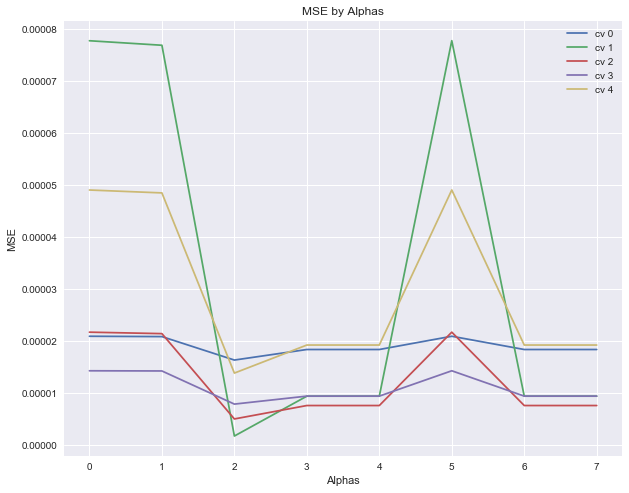

In [972]:
plt.figure(figsize=(10,8))

plt.legend()
for i in range(5):
    plt.plot(all_mse_scores[i],label = 'cv %s'%i)
plt.legend()
plt.xlabel('Alphas')
plt.ylabel('MSE')
plt.title('MSE by Alphas')
plt.show()

In [1093]:
from sklearn.linear_model import ElasticNetCV
elastic_cv = ElasticNetCV(cv=10,normalize = True,alphas=[
                       1e-10,1e-8,1e-5,1e-3,1e-1,0,1,100])
elastic_cv.fit(X_train1, y_train1)
alpha_elastic = elastic_cv.alpha_
elastic_coef = elastic_cv.coef_

In [1115]:
elastic_cv.l1_ratio_

0.5

In [1095]:
elastic_cv1.coef_

array([ 0.        ,  0.00087833,  0.02205839,  0.04596545, -0.        ,
        0.        ,  0.00840452, -0.        , -0.00097953,  0.01828487,
       -0.0014144 ,  0.        ,  0.01088714, -0.00706435,  0.00445365,
       -0.        , -0.00092664, -0.00477208,  0.00974569,  0.        ,
        0.        , -0.01483029,  0.02298997])

In [1299]:
elastic_cv1 = ElasticNet(1e-5,l1_ratio=.3) 

elastic_cv1.fit(X_train1, y_train1)


cv_score_elastic = cross_val_score(elastic_cv1, X_train1, y_train1, cv=5, scoring='mean_squared_error')
# cv_score_elastic_r2 = cross_val_score(elastic_cv1,X_train1, y_train1, cv=5, scoring='r2')

# elastic_cv1.fit(X_test1,y_test1)
elastic_cv1.score(X_test1,y_test1)


0.63888186365287902

In [1300]:
elastic_cv1.l1_ratio

0.5

In [1301]:
np.mean(-cv_score_elastic)

7.5015622479941857e-06

In [1098]:
np.mean(cv_score_elastic_r2)

0.56556556425986038

In [1099]:
np.mean(cv_score_elastic)

-8.4601650842017716e-06

In [1233]:
#Ridge Regularization

ridge_cv = RidgeCV(alphas=[
                       1e-10,1e-8,1e-5,1e-3,1e-1,0,1,100],cv=10)
ridge_cv.fit(X_train1, y_train1)
alpha_ridge = ridge_cv.alpha_
ridge_coef = ridge_cv.coef_
ridge_cv1 = Ridge(alpha_ridge)
ridge_cv1.fit(X_train1,y_train1)

print(ridge_cv1.score(X_test1,y_test1))
cv_score_ridge = cross_val_score(ridge_cv, X_train1, y_train1, cv=5, scoring='mean_squared_error')
cv_score_ridge_r2 = cross_val_score(ridge_cv, X_train1, y_train1, cv=5, scoring='r2')

np.mean(cv_score_ridge_r2)

0.517590513236


0.46545236517468586

In [1294]:
from sklearn.linear_model import LassoCV
lasso_cv = LassoCV(alphas=[
                       1e-10,1e-8,1e-5,1e-3,1e-1,0,1,100],cv=10)
lasso_cv.fit(X_train1, y_train1)
alpha_lasso = lasso_cv.alpha_
lasso_coef = lasso_cv.coef_
print(alpha_lasso)
# print(lassoT_coef)
lasso= Lasso(alpha_lasso)
lasso.fit(X_train1, y_train1)
lasso.score(X_test1, y_test1)

1e-08


0.50805494044007615

In [1306]:
lasso = Lasso(1e-5)
lasso.fit(X_train1,y_train1)
print(lasso.score(X_test1,y_test1))
lasso.coef_


0.678095560737


array([ 0.        ,  0.        ,  0.0180136 ,  0.03896534, -0.        ,
        0.        ,  0.00306937,  0.        , -0.        ,  0.01423052,
       -0.00217794,  0.        ,  0.00394829, -0.00499716,  0.        ,
       -0.        , -0.        , -0.00417706,  0.00850753,  0.        ,
        0.        , -0.00831214,  0.0255921 ])

In [1298]:
cv_score_lasso = cross_val_score(lasso,X_train1, y_train1, cv=5, scoring='mean_squared_error')
# r2_lasso = np.mean(-cv_score_lassoT) ** (0.5)
# r2_lasso
cv_score_lasso
# np.mean(-cv_score_lasso)

array([ -7.95917309e-06,  -6.78565721e-06,  -8.88029652e-06,
        -6.95555045e-06,  -9.52598211e-06])